# **Fashion MNIST Classification**
A FFNN (Feed Forward Neural Network) and CNN (Convolutional Nerual Network) have been modeled

## Import required packages

In [1]:
import torch 
from torchvision import transforms,datasets
import torch.nn as nn 
import torch.nn.functional as F
from torch.utils.data import SubsetRandomSampler
import matplotlib.pyplot as plt 
import numpy as np 


## Defining our Transforms

In [2]:
transform=transforms.Compose([transforms.ToTensor()])
# To get the Normalization values do the follwing after downloading train data
# print(train_data.data.float().mean()/255)
# print(train_data.data.float().std()/255)

## Gathering the train and test data

In [3]:
train_data=datasets.FashionMNIST('data',train=True,download=True,transform=transform)
test_data=datasets.FashionMNIST('data',train=False,download=True,transform=transform)

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Defining our Train, Valid and Test Dataloaders

In [4]:
valid_size=0.2
train_length=len(train_data)

indices=[i for i in range(train_length)]
np.random.shuffle(indices)

split=int(np.floor(valid_size*train_length))
train_idx=indices[split:]
valid_idx=indices[:split]


train_sampler=SubsetRandomSampler(train_idx)
valid_sampler=SubsetRandomSampler(valid_idx)

num_workers=0
batch_size=20
train_loader=torch.utils.data.DataLoader(train_data,batch_size=batch_size,sampler=train_sampler,num_workers=num_workers)
valid_loader=torch.utils.data.DataLoader(train_data,batch_size=batch_size,sampler=train_sampler,num_workers=num_workers)
test_loader=torch.utils.data.DataLoader(test_data,batch_size=batch_size,num_workers=num_workers)

# This is for debugging
print(f"Training data size : {train_idx.__len__()}, Validation data size : {valid_idx.__len__()}, Test data size : {test_loader.dataset.__len__()}")

Training data size : 48000, Validation data size : 12000, Test data size : 10000


In [5]:
# checking our data
dataiter=iter(train_loader)
images,labels=dataiter.next()
print(images, images.shape, len(images), images[0].shape)
print()
print(labels,labels.shape,len(labels))

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0.

## Visualizing a Training batch

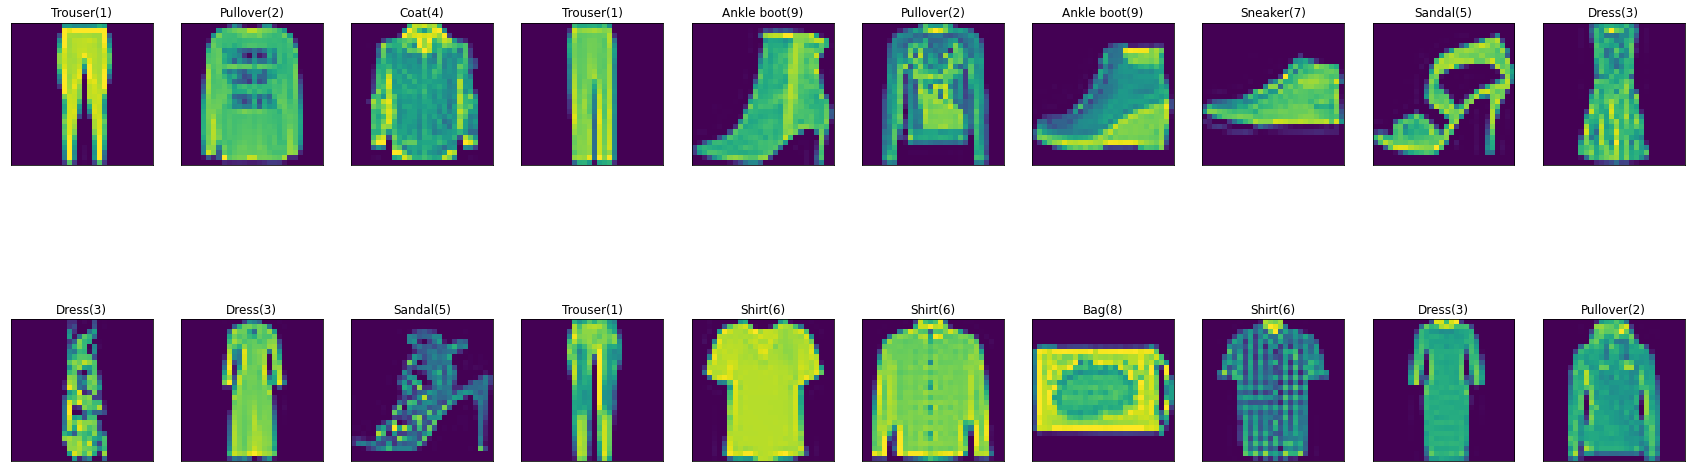

In [6]:
fashion_class={
    0:"T-shirt/top",
    1:"Trouser",
    2:"Pullover",
    3:"Dress",
    4:"Coat",
    5:"Sandal",
    6:"Shirt",
    7:"Sneaker",
    8:"Bag",
    9:"Ankle boot"
}

fig=plt.figure(figsize=(30,10))
for i in range(len(labels)):
    ax=fig.add_subplot(2,10,i+1,xticks=[],yticks=[])
    plt.imshow(np.squeeze(images[i]))
    ax.set_title(f"{fashion_class[labels[i].item()]}({labels[i].item()})")
    

## Defining our Neural Net Architecture

In [7]:

# Model 1 : This model has dropout set to a certain value
# NOTE : When we want to use dropout we ensure we run train() method on our model --- during training , if not required we should use eval() method --- validation and testing
class FNet(nn.Module):
    def __init__(self):
        super(FNet,self).__init__()
        self.fc1=nn.Linear(784,512)
        self.fc2=nn.Linear(512,256)
        self.out=nn.Linear(256,10)
        
        # Dropout probability - set for avoiding overfitting
        self.dropout=nn.Dropout(0.2)

    def forward(self,x):
        x = x.view(-1, 28 * 28)        
        x=self.dropout(F.relu(self.fc1(x)))
        x=self.dropout(F.relu(self.fc2(x)))
        x=self.out(x)
        return x

class convNet(nn.Module):
  def __init__(self):
    super(convNet,self).__init__()
    self.conv1=nn.Conv2d(in_channels=1,out_channels=16,kernel_size=3,padding=1,stride=1)
    self.conv2=nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,padding=1,stride=1)
    self.pool=nn.MaxPool2d(kernel_size=2,stride=2)


    self.fc1=nn.Linear(7*7*32,512)
    self.fc2=nn.Linear(512,256)
    self.out=nn.Linear(256,10)
    self.dropout=nn.Dropout(0.2)

  def forward(self,x):
    x=self.pool(F.relu(self.conv1(x)))
    x=self.pool(F.relu(self.conv2(x)))
    x=x.view(-1,7*7*32)
    x = self.dropout(x)
    x=self.dropout(F.relu(self.fc1(x)))
    x=self.dropout(F.relu(self.fc2(x)))
    x=self.out(x)
    return x
    

In [8]:
model_1=FNet()
model_2=convNet()
def weight_init_normal(m):
    classname=m.__class__.__name__
    if classname.find('Linear')!=-1:
        n = m.in_features
        y = (1.0/np.sqrt(n))
        m.weight.data.normal_(0, y)
        m.bias.data.fill_(0)
model_1.apply(weight_init_normal),model_2.apply(weight_init_normal)
use_cuda=True
if use_cuda and torch.cuda.is_available():
  model_1.cuda()
  model_2.cuda()


print(model_1,'\n\n\n\n',model_2,'\n\n\n\n','On GPU : ',torch.cuda.is_available())

FNet(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (out): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
) 



 convNet(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1568, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (out): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
) 



 On GPU :  True


## Defining our Loss Function

In [9]:
# Loss Function
# If we did not compute softmax at output use nn.CrossentropyLoss() else use nn.NLLLoss()
criterion=nn.CrossEntropyLoss()


## Training and Validation Phase

In [10]:
def trainNet(model,lr):
    optimizer=torch.optim.Adam(model.parameters(),lr=lr)


    # Number of epochs to train for
    loss_keeper={'train':[],'valid':[]}
    epochs=50

    # minimum validation loss ----- set initial minimum to infinity
    valid_loss_min = np.Inf 

    for epoch in range(epochs):
        train_loss=0.0
        valid_loss=0.0

        """
        TRAINING PHASE
        """
        model.train() # TURN ON DROPOUT for training
        for images,labels in train_loader:
            if use_cuda and torch.cuda.is_available():
                images,labels=images.cuda(),labels.cuda()
            optimizer.zero_grad()
            output=model(images)
            loss=criterion(output,labels)
            loss.backward()
            optimizer.step()
            train_loss+=loss.item()

        """
        VALIDATION PHASE
        """
        model.eval() # TURN OFF DROPOUT for validation
        for images,labels in valid_loader:
            if use_cuda and torch.cuda.is_available():
                images,labels=images.cuda(),labels.cuda()
            output=model(images)
            loss=criterion(output,labels)
            valid_loss+=loss.item()

        # Calculating loss over entire batch size for every epoch
        train_loss = train_loss/len(train_loader)
        valid_loss = valid_loss/len(valid_loader)


        # saving loss values
        loss_keeper['train'].append(train_loss)
        loss_keeper['valid'].append(valid_loss)

        print(f"\nEpoch : {epoch+1}\tTraining Loss : {train_loss}\tValidation Loss : {valid_loss}")
        if valid_loss<=valid_loss_min:
            print(f"Validation loss decreased from : {valid_loss_min} ----> {valid_loss} ----> Saving Model.......")
            z=type(model).__name__
            torch.save(model.state_dict(), z+'_model.pth')
            valid_loss_min=valid_loss
    return(loss_keeper)

In [11]:
m1_loss=trainNet(model_1,0.001)


Epoch : 1	Training Loss : 0.5245737774328639	Validation Loss : 0.40727028745692223
Validation loss decreased from : inf ----> 0.40727028745692223 ----> Saving Model.......

Epoch : 2	Training Loss : 0.41205299500686426	Validation Loss : 0.33708525497854375
Validation loss decreased from : 0.40727028745692223 ----> 0.33708525497854375 ----> Saving Model.......

Epoch : 3	Training Loss : 0.37512027808232234	Validation Loss : 0.3269843166414648
Validation loss decreased from : 0.33708525497854375 ----> 0.3269843166414648 ----> Saving Model.......

Epoch : 4	Training Loss : 0.35627668351400643	Validation Loss : 0.2958452573659209
Validation loss decreased from : 0.3269843166414648 ----> 0.2958452573659209 ----> Saving Model.......

Epoch : 5	Training Loss : 0.3396964971123574	Validation Loss : 0.30502018353901805

Epoch : 6	Training Loss : 0.32586353985515115	Validation Loss : 0.2715637166778712
Validation loss decreased from : 0.2958452573659209 ----> 0.2715637166778712 ----> Saving Mode

In [12]:
m1_loss

{'train': [0.5245737774328639,
  0.41205299500686426,
  0.37512027808232234,
  0.35627668351400643,
  0.3396964971123574,
  0.32586353985515115,
  0.31807561103021725,
  0.30708983439641696,
  0.30403845171366506,
  0.29128749907889867,
  0.28766232713048034,
  0.2831367064003522,
  0.27554270743974485,
  0.2725916432214823,
  0.26784925135201776,
  0.26537928035346947,
  0.259906140359235,
  0.25951209691023297,
  0.25233723516304357,
  0.25175181417997616,
  0.24591592026738604,
  0.24436698967086462,
  0.24083079281728714,
  0.23969198762138452,
  0.23489664492231288,
  0.23563934576805573,
  0.23154691223055124,
  0.22806961808829024,
  0.22848473104221437,
  0.2227636545842203,
  0.22040115774972946,
  0.22619962989165893,
  0.22031544507665482,
  0.21519330151876603,
  0.2193748861432969,
  0.2162219042679741,
  0.21072389956447296,
  0.21120259532281732,
  0.21253237069477715,
  0.20905702414408248,
  0.20989730593952116,
  0.1989290834204682,
  0.2002430260998517,
  0.202289959

In [13]:
m2_loss=trainNet(model_2,0.001)


Epoch : 1	Training Loss : 0.4795484571158886	Validation Loss : 0.31273220816549535
Validation loss decreased from : inf ----> 0.31273220816549535 ----> Saving Model.......

Epoch : 2	Training Loss : 0.3173350762700041	Validation Loss : 0.23918204094166867
Validation loss decreased from : 0.31273220816549535 ----> 0.23918204094166867 ----> Saving Model.......

Epoch : 3	Training Loss : 0.27447949518798853	Validation Loss : 0.2130895116176301
Validation loss decreased from : 0.23918204094166867 ----> 0.2130895116176301 ----> Saving Model.......

Epoch : 4	Training Loss : 0.24477813980154073	Validation Loss : 0.18251645672591016
Validation loss decreased from : 0.2130895116176301 ----> 0.18251645672591016 ----> Saving Model.......

Epoch : 5	Training Loss : 0.2235558565330575	Validation Loss : 0.1694691702640072
Validation loss decreased from : 0.18251645672591016 ----> 0.1694691702640072 ----> Saving Model.......

Epoch : 6	Training Loss : 0.20756078502541642	Validation Loss : 0.1476750

In [14]:
m2_loss

{'train': [0.4795484571158886,
  0.3173350762700041,
  0.27447949518798853,
  0.24477813980154073,
  0.2235558565330575,
  0.20756078502541642,
  0.19212437911415084,
  0.18010585031496398,
  0.16571191259402743,
  0.15943761572215104,
  0.1476734644507936,
  0.13949095874687675,
  0.13538698722348877,
  0.12676684644667452,
  0.12330863882613509,
  0.11797290926730057,
  0.11228519654245853,
  0.10714266181970136,
  0.09973824333054533,
  0.10129936376109375,
  0.09411663640320436,
  0.09561268586283328,
  0.09034627869266236,
  0.08844642914188322,
  0.08562387986816626,
  0.08477398798667825,
  0.08143051965540432,
  0.08055603952888134,
  0.07787930377843869,
  0.07576567459934179,
  0.07473747702523004,
  0.07545270113245768,
  0.07152779797578404,
  0.0742624747035643,
  0.06874973939579182,
  0.07102298685327421,
  0.06724359062363788,
  0.06734503121469843,
  0.0640434335701202,
  0.0676434264319304,
  0.06762472466224609,
  0.06139595134342544,
  0.0659437619101114,
  0.064305

## Loading model from Lowest Validation Loss

In [15]:
# Loading the model from the lowest validation loss 
model_1.load_state_dict(torch.load('FNet_model.pth'))
model_2.load_state_dict(torch.load('convNet_model.pth'))


<All keys matched successfully>

In [16]:
print(model_1.state_dict,'\n\n\n\n',model_2.state_dict)

<bound method Module.state_dict of FNet(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (out): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)> 



 <bound method Module.state_dict of convNet(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1568, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (out): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)>


## Plotting Training and Validation Losses

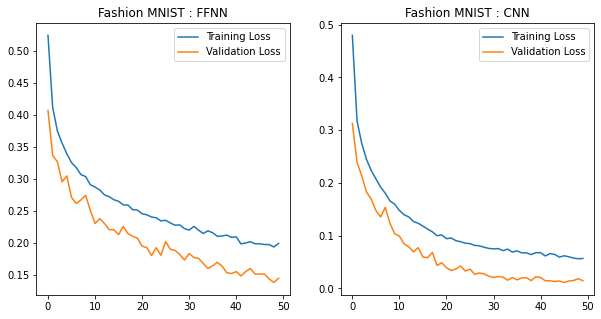

In [17]:
title=['FFNN','CNN']
model_losses=[m1_loss,m2_loss]
fig=plt.figure(1,figsize=(10,5))
idx=1
for i in model_losses:
  ax=fig.add_subplot(1,2,idx)
  ax.plot(i['train'],label="Training Loss")
  ax.plot(i['valid'],label="Validation Loss")
  ax.set_title('Fashion MNIST : '+title[idx-1])
  idx+=1
  plt.legend();

## Testing Phase

In [18]:
def test(model):
    correct=0
    test_loss=0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))

    model.eval() # test the model with dropout layers off
    for images,labels in test_loader:
        if use_cuda and torch.cuda.is_available():
            images,labels=images.cuda(),labels.cuda()
        output=model(images)
        loss=criterion(output,labels)
        test_loss+=loss.item()
        _,pred=torch.max(output,1)
        correct = np.squeeze(pred.eq(labels.data.view_as(pred)))

        for i in range(batch_size):
            label = labels.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1


    test_loss=test_loss/len(test_loader)
    print(f'For {type(model).__name__} :')
    print(f"Test Loss: {test_loss}")
    print(f"Correctly predicted per class : {class_correct}, Total correctly perdicted : {sum(class_correct)}")
    print(f"Total Predictions per class : {class_total}, Total predictions to be made : {sum(class_total)}\n")
    for i in range(10):
      if class_total[i] > 0:
          print(f"Test Accuracy of class {fashion_class[i]} : {float(100 * class_correct[i] / class_total[i])}% where {int(np.sum(class_correct[i]))} of {int(np.sum(class_total[i]))} were predicted correctly")
      else:
          print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

    print(f"\nOverall Test Accuracy : {float(100. * np.sum(class_correct) / np.sum(class_total))}% where {int(np.sum(class_correct))} of {int(np.sum(class_total))} were predicted correctly")
    # obtain one batch of test images
    dataiter = iter(test_loader)
    images, labels = dataiter.next()

    # get sample outputs
    if use_cuda and torch.cuda.is_available():
      images,labels=images.cuda(),labels.cuda()
    output = model(images)
    
    # convert output probabilities to predicted class
    _, preds = torch.max(output, 1)
    # prep images for display
    images = images.cpu().numpy()

    fig = plt.figure(figsize=(15, 20))
    for idx in np.arange(batch_size):
        ax = fig.add_subplot(5, batch_size/5, idx+1, xticks=[], yticks=[])
        plt.imshow(np.squeeze(images[idx]))
        ax.set_title("{}-{} for ({}-{})".format(str(preds[idx].item()), fashion_class[preds[idx].item()],str(labels[idx].item()),fashion_class[labels[idx].item()]),
                    color=("blue" if preds[idx]==labels[idx] else "red"))

## Visualizing a Test batch with results

### FFNN

For FNet :
Test Loss: 0.46673072340362703
Correctly predicted per class : [866.0, 971.0, 820.0, 932.0, 788.0, 962.0, 669.0, 974.0, 977.0, 950.0], Total correctly perdicted : 8909.0
Total Predictions per class : [1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0], Total predictions to be made : 10000.0

Test Accuracy of class T-shirt/top : 86.6% where 866 of 1000 were predicted correctly
Test Accuracy of class Trouser : 97.1% where 971 of 1000 were predicted correctly
Test Accuracy of class Pullover : 82.0% where 820 of 1000 were predicted correctly
Test Accuracy of class Dress : 93.2% where 932 of 1000 were predicted correctly
Test Accuracy of class Coat : 78.8% where 788 of 1000 were predicted correctly
Test Accuracy of class Sandal : 96.2% where 962 of 1000 were predicted correctly
Test Accuracy of class Shirt : 66.9% where 669 of 1000 were predicted correctly
Test Accuracy of class Sneaker : 97.4% where 974 of 1000 were predicted correctly
Test Accuracy 

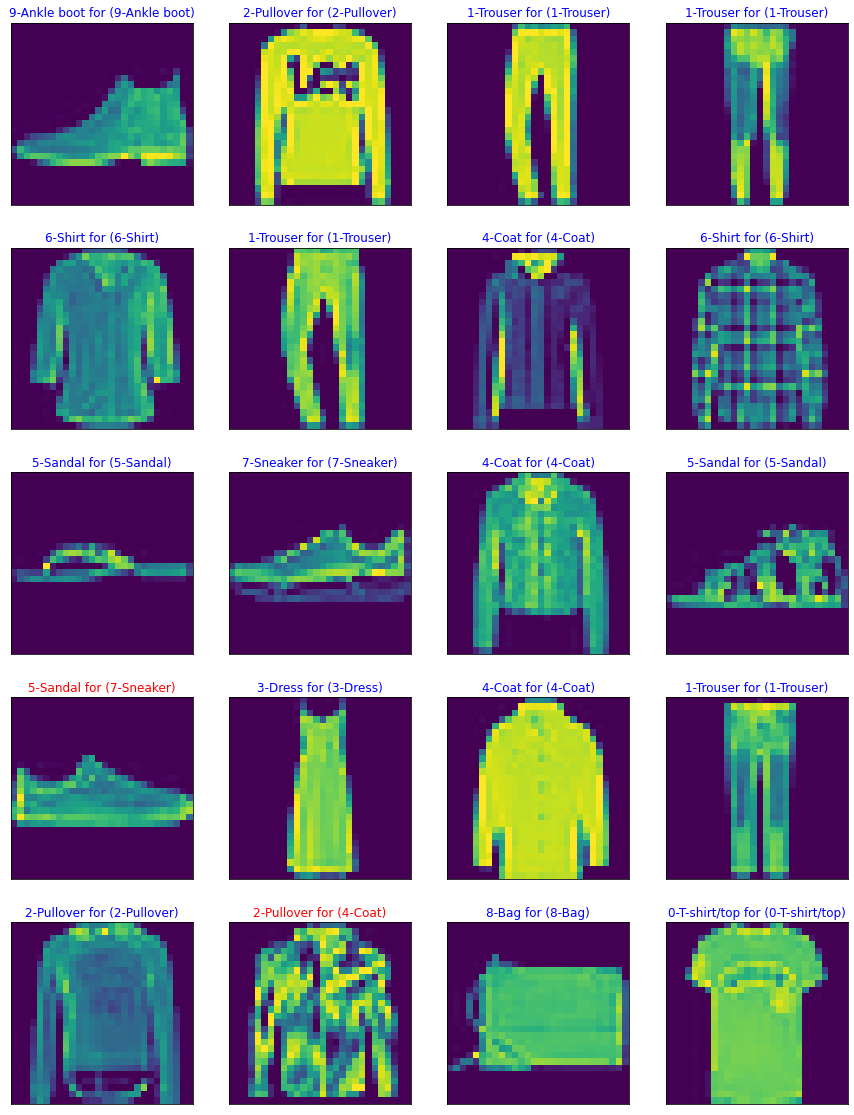

In [19]:
test(model_1)

### CNN

For convNet :
Test Loss: 0.42782994577231603
Correctly predicted per class : [861.0, 984.0, 873.0, 902.0, 878.0, 982.0, 746.0, 985.0, 985.0, 965.0], Total correctly perdicted : 9161.0
Total Predictions per class : [1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0], Total predictions to be made : 10000.0

Test Accuracy of class T-shirt/top : 86.1% where 861 of 1000 were predicted correctly
Test Accuracy of class Trouser : 98.4% where 984 of 1000 were predicted correctly
Test Accuracy of class Pullover : 87.3% where 873 of 1000 were predicted correctly
Test Accuracy of class Dress : 90.2% where 902 of 1000 were predicted correctly
Test Accuracy of class Coat : 87.8% where 878 of 1000 were predicted correctly
Test Accuracy of class Sandal : 98.2% where 982 of 1000 were predicted correctly
Test Accuracy of class Shirt : 74.6% where 746 of 1000 were predicted correctly
Test Accuracy of class Sneaker : 98.5% where 985 of 1000 were predicted correctly
Test Accura

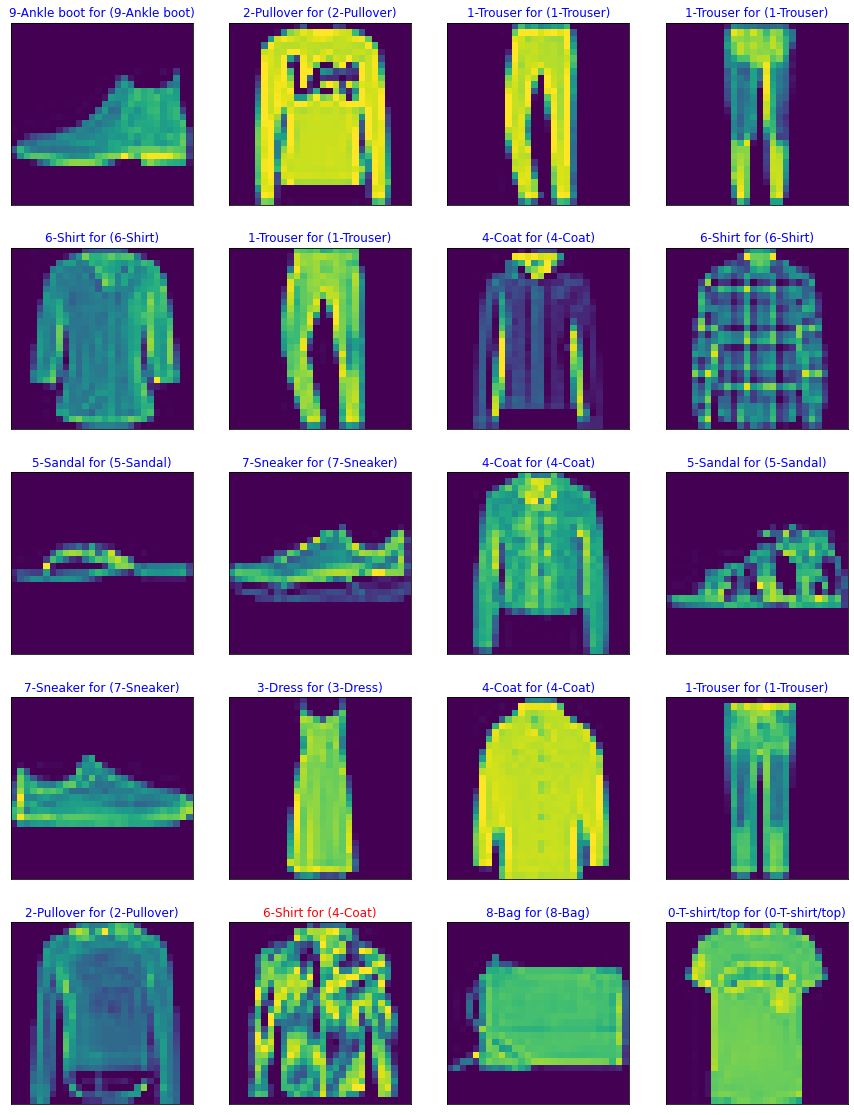

In [20]:
test(model_2)